[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Revisão

Construímos um graph simples com nodes, normal edges e conditional edges.

## Objetivos

Agora, vamos construir até uma chain simples que combina 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Uso de [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) como nosso graph state
* Uso de [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) em graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) ao nosso chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) em graph nodes

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

Chat models podem usar [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), que capturam diferentes roles dentro de uma conversa.

LangChain suporta vários tipos de message, incluindo `HumanMessage`, `AIMessage`, `SystemMessage` e `ToolMessage`.

Estas representam uma mensagem do usuário, do chat model, para o chat model instruir comportamento, e de uma tool call.

Vamos criar uma lista de messages.

Cada message pode ser fornecida com algumas coisas:

* `content` - conteúdo da mensagem
* `name` - opcionalmente, um autor da mensagem
* `response_metadata` - opcionalmente, um dict de metadados (por exemplo, frequentemente preenchido pelo provedor do modelo para `AIMessages`)

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) podem usar uma sequência de message como input e suportar tipos de message, como discutido acima.

Existem [muitos](https://python.langchain.com/v0.2/docs/concepts/#chat-models) para escolher! Vamos trabalhar com OpenAI.

Vamos verificar se sua `OPENAI_API_KEY` está configurada e, se não estiver, você será solicitado a inseri-la.

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Podemos carregar um chat model e invocá-lo com nossa lista de messages.

Podemos ver que o resultado é uma `AIMessage` com `response_metadata` específicos.

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
result

AIMessage(content='The Pacific Northwest, particularly the waters around the San Juan Islands in Washington State, is one of the best places in the United States to see orcas, also known as killer whales, in the wild. \n\nThe San Juan Islands are located in the Salish Sea, which is home to several pods of Southern Resident orcas. These islands provide a natural habitat for orcas due to the abundance of salmon, their primary food source. Orca sightings are most common between May and October, which is the peak season for whale watching.\n\nThere are numerous whale-watching tours available in the area that offer a chance to see these magnificent creatures up close while emphasizing responsible and sustainable wildlife viewing practices.\n\nIn addition to the San Juan Islands, other locations along the West Coast, such as the waters near Seattle and the Olympic Peninsula, also offer opportunities to observe orcas in their natural environment.', additional_kwargs={'refusal': None}, respons

In [6]:
result.response_metadata

{'token_usage': {'completion_tokens': 177,
  'prompt_tokens': 67,
  'total_tokens': 244,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_f5bdcc3276',
 'id': 'chatcmpl-BWYkyz3nl0JAQRLyx8a3UCmXHpV8Z',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools são úteis sempre que você deseja que um modelo interaja com sistemas externos.

Sistemas externos (por exemplo, APIs) frequentemente requerem um schema de entrada ou payload específico, em vez de linguagem natural.

Quando vinculamos uma API, por exemplo, como uma tool, damos ao modelo conhecimento do schema de entrada necessário.

O modelo escolherá chamar uma tool com base na entrada em linguagem natural do usuário.

E retornará uma saída que adere ao schema da tool.

[Muitos provedores de LLM suportam tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) e a [interface de tool calling](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) no LangChain é simples.

Você pode simplesmente passar qualquer `function` Python para `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Vamos mostrar um exemplo simples de tool calling!

A função `multiply` é nossa tool.

In [8]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

Se passarmos um input - por exemplo, `"What is 2 multiplied by 3"` - vemos um tool call retornado.

O tool call tem arguments específicos que correspondem ao schema de input da nossa function, junto com o name da function a ser chamada.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [9]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [11]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_66zSQwocT2cGFjX7EL24kg8G',
  'type': 'tool_call'}]

## Usando messages como state

Com essas fundações estabelecidas, agora podemos usar [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) em nosso graph state.

Vamos definir nosso state, `MessagesState`, como um `TypedDict` com uma única key: `messages`.

`messages` é simplesmente uma lista de messages, como definimos acima (por exemplo, `HumanMessage`, etc).

In [12]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Agora, temos um pequeno problema!

Como discutimos, cada node retornará um novo valor para nossa state key `messages`.

Mas este novo valor [substituirá](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) o valor anterior de `messages`.

Conforme nosso graph é executado, queremos **anexar** messages à nossa state key `messages`.

Podemos usar [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) para resolver isso.

Reducers nos permitem especificar como as atualizações de state são realizadas.

Se nenhuma reducer function for especificada, assume-se que as atualizações para a key devem *substituí-la* como vimos antes.

Mas, para anexar messages, podemos usar o reducer pré-construído `add_messages`.

Isso garante que quaisquer messages sejam anexadas à lista existente de messages.

Simplesmente precisamos anotar nossa key `messages` com a reducer function `add_messages` como metadata.

In [13]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [14]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [15]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='7b6f828d-967d-4269-99ce-4a262e016a38'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='e220b2c6-04be-4570-ae8f-5cffe632bdd6'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='9ff3049d-58e1-4924-b012-3cb84f12a9d4')]

## Our graph

Now, lets use `MessagesState` with a graph.

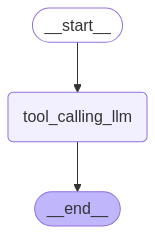

In [16]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [17]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [18]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_O09eas0nzxvRHX4iPNEFCtFD)
 Call ID: call_O09eas0nzxvRHX4iPNEFCtFD
  Args:
    a: 2
    b: 3
